In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd 
import sqlite3 as sql
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
from rascals.coordinates import _angularToCartesian

In [3]:
con = sql.connect("../data/objects.db")
data = pd.read_sql("""SELECT * FROM ephemeris
                      WHERE night = 59584 AND ((ra_deg BETWEEN 240 AND 250)
                         AND (dec_deg BETWEEN -25 AND -15))""", con)
coords_ec_cart = data[['HEclObj_X_au', 'HEclObj_Y_au', 'HEclObj_Z_au']].as_matrix()
coords_eq_ang_deg = data[["RA_deg", "Dec_deg"]].as_matrix()

In [4]:
def angularToGnomonic(coords_ang, coords_ang_center=np.array([0, 0])):
    """
    Project angular spherical coordinates onto a gnomonic tangent plane. 
    
    Parameters
    ----------
    coords_ang : `~np.ndarray` (N, 2)
        Longitude (between 0 and 2 pi) and latitude (between -pi/2 and pi/2)
        in radians.
    coords_ang_center : `~np.ndarray` (2), optional
        Longitude (between 0 and 2 pi) and latitude (between -pi/2 and pi/2)
        in radians about which to center projection.
        [Default = np.array([0, 0])]
        
    Returns
    -------
    coords_gnomonic : `~np.ndarray` (N, 2)
        Gnomonic longitude and latitude in radians.
    """
    lon = coords_ang[:, 0] 
    lon = np.where(lon > np.pi, lon - 2*np.pi, lon)
    lat = coords_ang[:, 1]
    lon_0, lat_0 = coords_ang_center
    
    c = np.sin(lat_0) * np.sin(lat) + np.cos(lat_0) * np.cos(lat) * np.cos(lon - lon_0)
    u = np.cos(lat) * np.sin(lon - lon_0) / c
    v = (np.cos(lat_0) * np.sin(lat) - np.sin(lat_0) * np.cos(lat) * np.cos(lon - lon_0)) / c
    return np.array([u, v]).T

def cartesianToGnomonic(coords_cart):
    """
    Project cartesian coordinates onto a gnomonic tangent plane centered about
    the x-axis. 
    
    Parameters
    ----------
    coords_cart : `~np.ndarray` (N, 3)
        Cartesian equatorial x, y, z coordinates.
            
    Returns
    -------
    coords_gnomonic : `~np.ndarray` (N, 2)
        Gnomonic longitude and latitude in radians.
    """
    u = coords_cart[:,1] / coords_cart[:,0]
    v = coords_cart[:,2] / coords_cart[:,0]
    return np.array([u, v]).T

def gnomonicToAngular(coords_gnomonic, coords_ang_center=np.array([0, 0])):
    """
    Transform gnomonic tangent coordinates to spherical angular coordinates.
    
    BUG: Transform doesn't reproduce input.
    
    Parameters
    ----------
    coords_gnomonic : `~np.ndarray` (N, 2)
        Gnomonic longitude and latitude in radians. 
    coords_ang_center : `~np.ndarray` (2), optional
        Longitude (between 0 and 2 pi) and latitude (between -pi/2 and pi/2)
        in radians about which to center projection.
        [Default = np.array([0, 0])]
        
    Returns
    -------
    coords_ang : `~np.ndarray` (N, 2)
        Longitude (between 0 and 2 pi) and latitude (between -pi/2 and pi/2)
        in radians.
    """
    u = coords_gnomonic[:, 0] 
    v = coords_gnomonic[:, 1]
    lon_0, lat_0 = coords_ang_center
    
    rho = np.sqrt(u**2 + v**2)
    c = np.arctan(rho)
    
    lat = np.arcsin(np.cos(c) * np.sin(lat_0) + v * np.sin(c) * np.cos(lat_0) / rho)
    lon = lon_0 + np.arctan2(u * np.sin(c), (rho * np.cos(lat_0) * np.cos(c) - v * np.cos(lat_0) * np.sin(c)))
    #lon = np.where(lon < 0, lon + 2*np.pi, lon)
    return np.array([lon, lat]).T
    

In [5]:
# Define cardinal axes in cartesian coordinates
x_axis = np.array([[1, 0, 0]])
y_axis = np.array([[0, 1, 0]])
z_axis = np.array([[0, 0, 1]])
axes = np.vstack([x_axis, y_axis, z_axis])

# Define cardinal axes in angular coordinates
x_axis_ang = np.array([[0, 0, 1]])
neg_x_axis_ang = np.array([[np.pi, 0, 1]])
y_axis_ang = np.array([[np.pi/2, 0, 1]]) 
neg_y_axis_ang = np.array([[3*np.pi/2, 0, 1]]) 
z_axis_ang = np.array([[0, np.pi/2, 1]]) 
neg_z_axis_ang = np.array([[0, -np.pi/2, 1]]) 


In [6]:
a = angularToGnomonic(np.radians(coords_eq_ang_deg))
b = gnomonicToAngular(a)

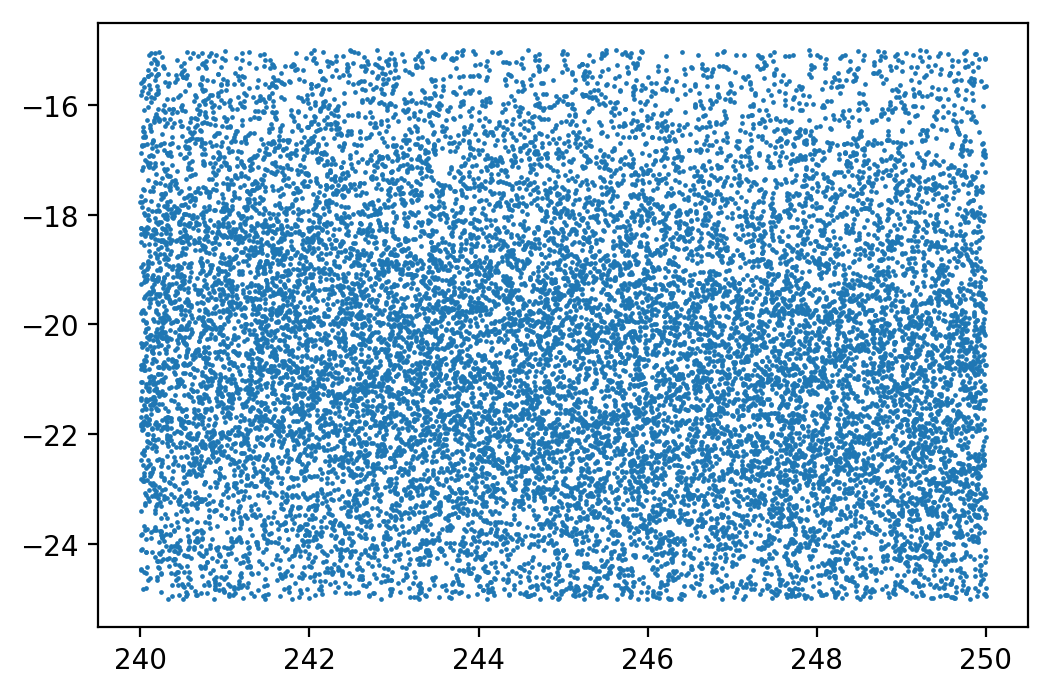

In [7]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*coords_eq_ang_deg.T, s=0.5)

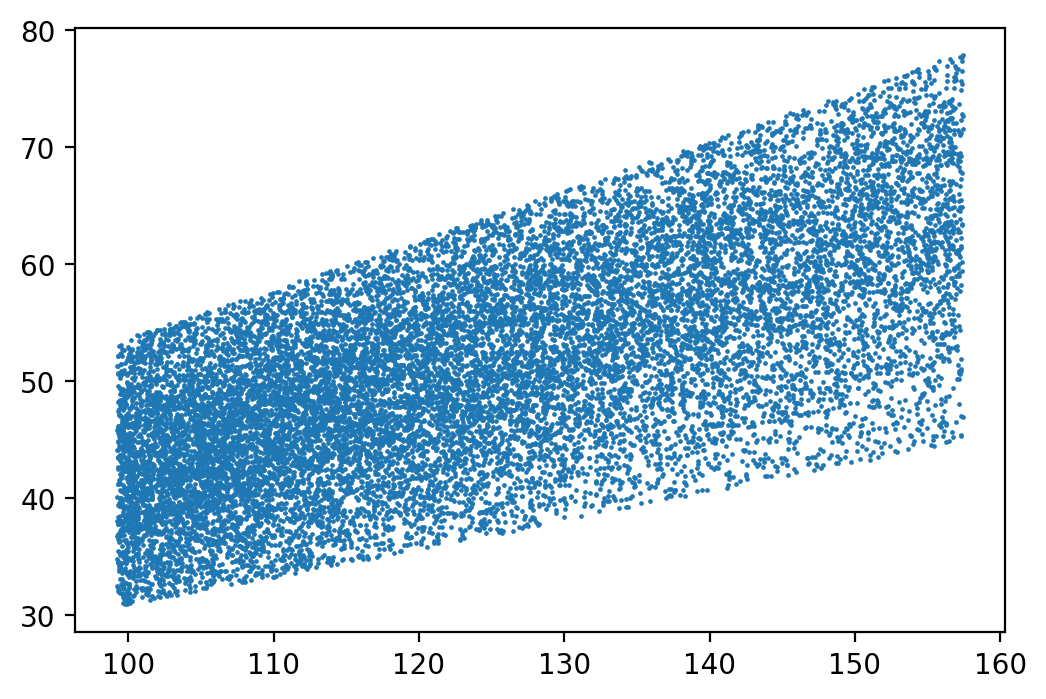

In [8]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*np.degrees(a.T), s=0.5)

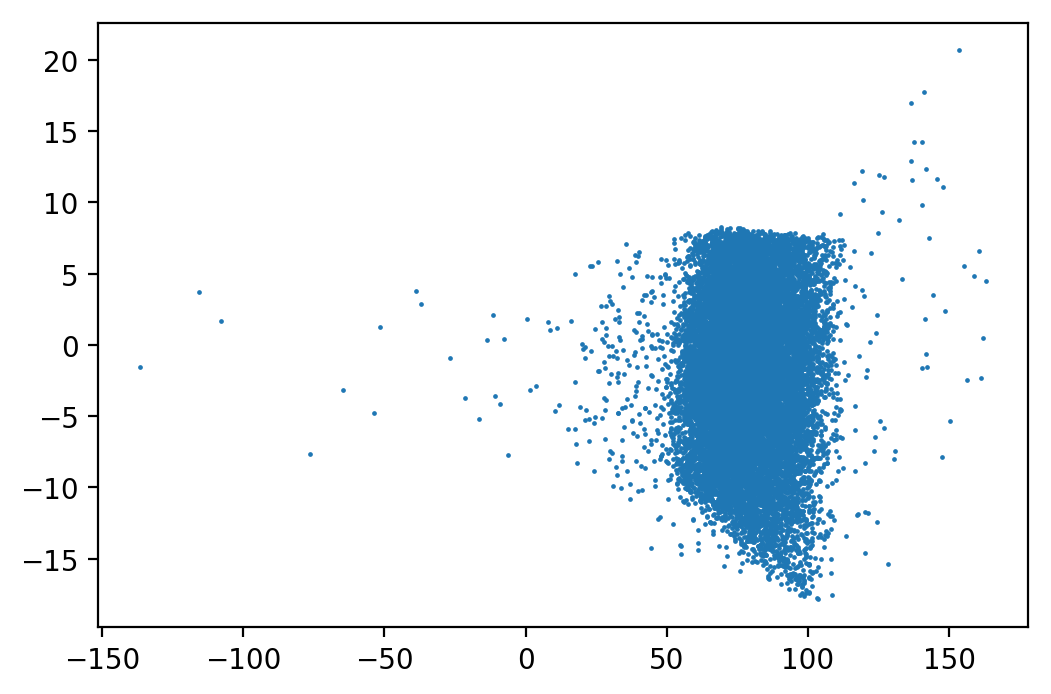

In [9]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*np.degrees(cartesianToGnomonic(coords_ec_cart)).T, s=0.5)

In [10]:
x_axis = np.array([1, 0, 0])
y_axis = np.array([0, 1, 0])
z_axis = np.array([0, 0, 1])

def calcNae(coords_ec_ang):
    """
    Convert angular ecliptic coordinates to 
    to a cartesian unit vector. 
    
    Input coordinate array should have shape (N, 2):
    np.array([[lon1, lat1],
              [lon2, lat2],
              [lon3, lat3],
                  .....
              [lonN, latN]])
    
    Parameters
    ----------
    coords_ec_ang : `~np.ndarray` (N, 2)
        Ecliptic longitude and latitude in radians.
        
    Returns
    -------
    N_ae : `~np.ndarray` (N, 3)
        Cartesian unit vector in direction of provided
        angular coordinates.
    """
    return _angularToCartesian(coords_ec_ang[:,0], coords_ec_ang[:,1], 1)

def calcDelta(r, x_e, n_ae):
    """
    Calculate topocentric distance to the asteroid. 
    
    Parameters
    ----------
    r : float
        Heliocentric distance in arbitrary units.
    x_e : `~np.ndarray` (3)
        Topocentric position vector in same units as r. 
    n_ae : `~np.ndarray` (3)
        Unit vector in direction of asteroid from the topocentric position
        in same units as r.
    
    Returns
    -------
    delta : float
        Distance from topocenter to asteroid in units of r. 
    """
    return - np.dot(n_ae, x_e) + np.sqrt(norm(np.dot(n_ae, x_e))**2 + r**2 - norm(x_e)**2)

def calcXae(delta, n_ae):
    """
    Calculate the topocenter to asteroid position vector. 
    
    Parameters
    ----------
    delta : float
        Distance from the topocenter to asteroid in arbitrary units.
    n_ae : `~np.ndarray` (3)
        Unit vector in direction of asteroid from the topocentric position
        in same units as delta.
        
    Returns
    -------
    x_ae : `~np.ndarray` (3)
        Topocenter to asteroid position vector in units of delta. 
    """
    return np.dot(delta, n_ae)

def calcXa(x_ae, x_e):
    """
    Calculate the barycentric asteroid position vector. 
    
    Parameters
    ----------
    x_ae : `~np.ndarray` (3)
        Topocenter to asteroid position vector in arbitrary units. 
    x_e : `~np.ndarray` (3)
        Topocentric position vector in same units as x_ae. 
        
    Returns
    -------
    x_a : `~np.ndarray` (3)
        Barycentric asteroid position vector in units of x_ae.
    """
    return x_ae + x_e

def calcR1(x_a):
    """
    Calculate the rotation matrix that would rotate the barycentric
    position vector x_ae to the x-y plane. 
    
    Parameters
    ----------
    x_a : `~np.ndarray` (3)
        Barycentric asteroid position vector in arbitrary units.
    
    Returns
    -------
    R1 : `~np.matrix` (3, 3)
        Rotation matrix.
    """
    # Find the unit vector in the direction of an asteroid or 
    # test particle n_a
    n_a = x_a / norm(x_a)
    # Find the normal to the plane of the orbit n_hat
    n_hat = np.cross(np.cross(n_a, z_axis), r_hat)
    # Find the rotation axis v
    v = np.cross(n_hat, z_axis)
    # Calculate the cosine of the rotation angle, equivalent to the cosine of the
    # inclination
    c = np.dot(n_hat, z_axis)
    # Compute the skew-symmetric cross-product of the rotation axis vector v
    vp = np.matrix([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    # Calculate R1 and return
    return np.identity(3) + vp + vp**2 * (1 / (1 + c))

def calcR2(x_a_xy):
    """
    Calculate the rotation matrix that would rotate a vector in
    the x-y plane to the x-axis. 
    
    Parameters
    ----------
    x_a_xy : `~np.ndarray` (3)
        Barycentric asteroid position vector rotated to the x-y plane.
        
    Returns
    -------
    R2 : `~np.matrix` (3, 3)
        Rotation matrix.
    """
    alpha = np.dot(-x_axis, x_a_xy)
    return np.matrix([[np.cos(alpha), -np.sin(alpha), 0],
                      [np.sin(alpha), np.cos(alpha), 0],
                      [0, 0, 1]])

In [12]:
r = np.array([1, 1, 1])
r_hat = r / norm(r)
print(r)
n_hat = np.cross(np.cross(r_hat, z_axis), r_hat)
print(n_hat)

r1 = calcR1(r)
np.linalg.det(r1)

[1 1 1]
[-0.33333333 -0.33333333  0.66666667]


0.9733333333333334

In [13]:
r1.T

matrix([[ 0.93333333, -0.06666667, -0.33333333],
        [-0.06666667,  0.93333333, -0.33333333],
        [ 0.33333333,  0.33333333,  0.86666667]])

In [14]:
# Float precision is going to be a problem here.
np.linalg.inv(r1) 

matrix([[ 0.94520548, -0.05479452, -0.34246575],
        [-0.05479452,  0.94520548, -0.34246575],
        [ 0.34246575,  0.34246575,  0.89041096]])